# IHDP Data

Import of all needed libraries, numpy, pandas, matplot, sckitlearn, some will be used further on. 

In [16]:
!pip install econml

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Data import and structure checking, we are able to see that the characteristics "x", we have treatment "t", the outcome "yf" and counter "ycf" and the indivudial treatment effect "ite".

In [18]:
!wget "https://github.com/dmachlanski/CE888_2022/blob/main/project/data/ihdp.npz?raw=true" -O "ihdp.npz"

--2022-04-27 11:43:53--  https://github.com/dmachlanski/CE888_2022/blob/main/project/data/ihdp.npz?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dmachlanski/CE888_2022/raw/main/project/data/ihdp.npz [following]
--2022-04-27 11:43:53--  https://github.com/dmachlanski/CE888_2022/raw/main/project/data/ihdp.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.npz [following]
--2022-04-27 11:43:53--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... con

In [19]:
df = np.load('ihdp.npz')

df.files

['x', 't', 'yf', 'ycf', 'ite']

Check for missing values and the shape of the dataframe. There are the 29 columns, the 5 mentioned above, in which "x" is an array of 25x747, meaning there are 25 background variables. Each column contains 747 rows of data, including the labels. Also we noticed there are no missing values in any column.

In [20]:
for data in df.files:
  print(f'{data}: {df[data].shape, df[data].dtype}')

x: ((747, 25), dtype('float64'))
t: ((747, 1), dtype('float64'))
yf: ((747, 1), dtype('float64'))
ycf: ((747, 1), dtype('float64'))
ite: ((747, 1), dtype('float64'))


As we can see our background features "x" are divided in 25 columns, which will be merged for a better analysis when visualizing the data. There is also noticeable that this dataset contains the outcome factuals and counterfactuals, which tells us it has simulated outcomes (since it is not common to have both, as we can not go back in time). And instead of the effect, we are given the _Individual Treatment Effect_.

In [21]:
X = df['x']
T = df['t'].reshape(-1, 1)
Yf = df['yf'].reshape(-1, 1)
Ycf = df['ycf'].reshape(-1, 1)
ite = df['ite']

To have a better understandment of the behaviour of the data, we will plot it's histograms.

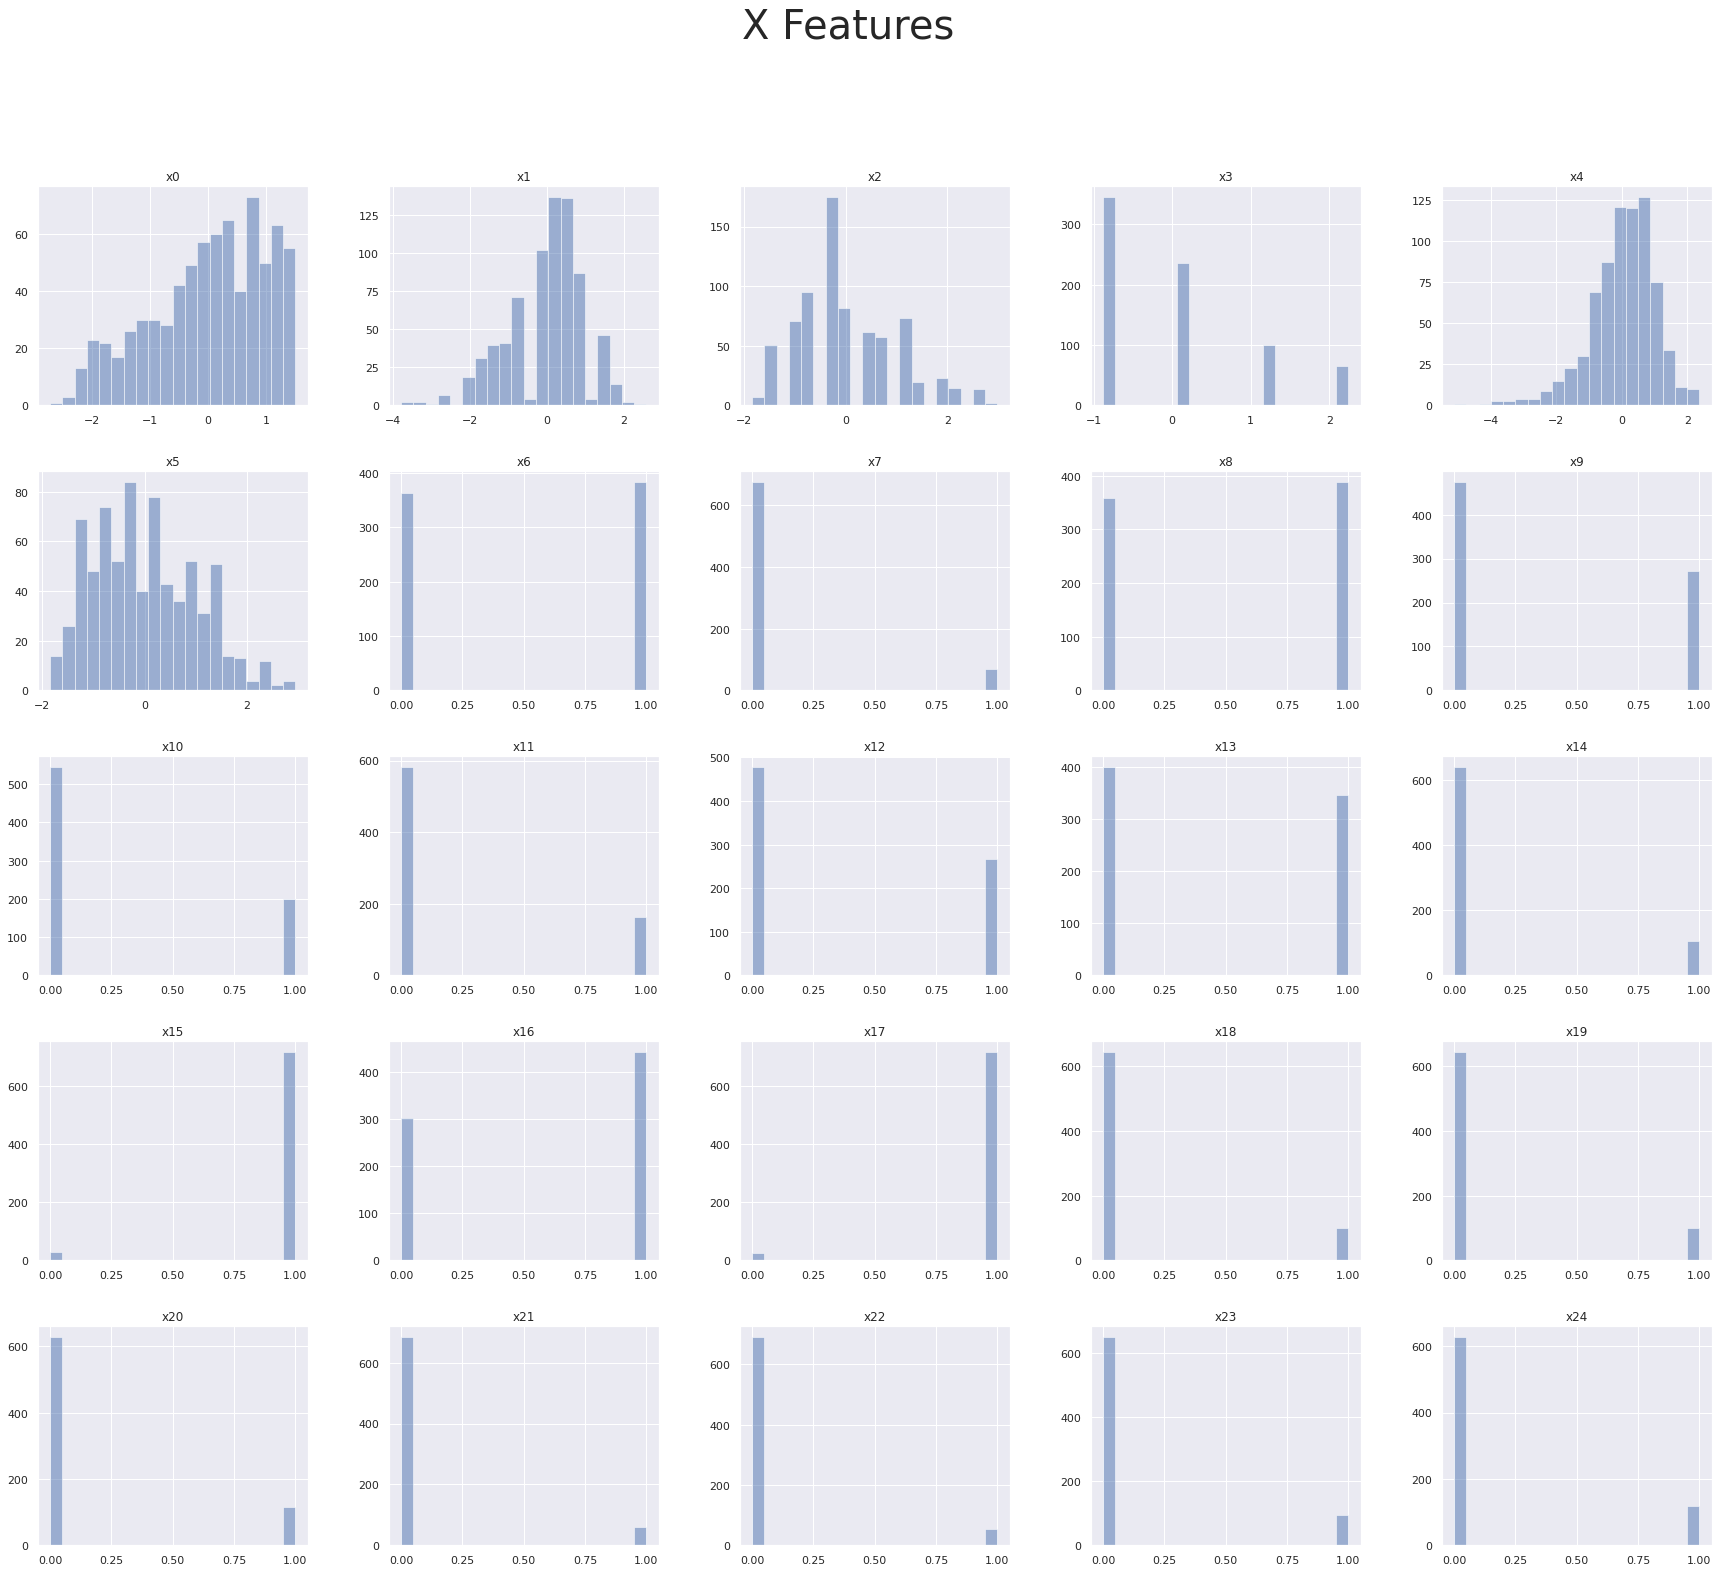

In [39]:
xName = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24"]
Xp = pd.DataFrame(data=X)
Xp.columns=xName


axes = Xp.hist(color='b', alpha=0.5, bins=20, figsize=(30,25), layout=(5, 5))
sns.set(font_scale=1.5)
plt.suptitle("X Features", size=40)

plt.savefig("ihdp_xFeatures.pdf", dpi=1500)


The histograms of the _X_ features were displayed in an individual manner for the exploration of their type per column, this as the file loaded was a npz file that has all the _X_ features concatenated in a single 2-Dimensional array. This also allows us to view that throughout the 25 features we have 6 of them being continuous.

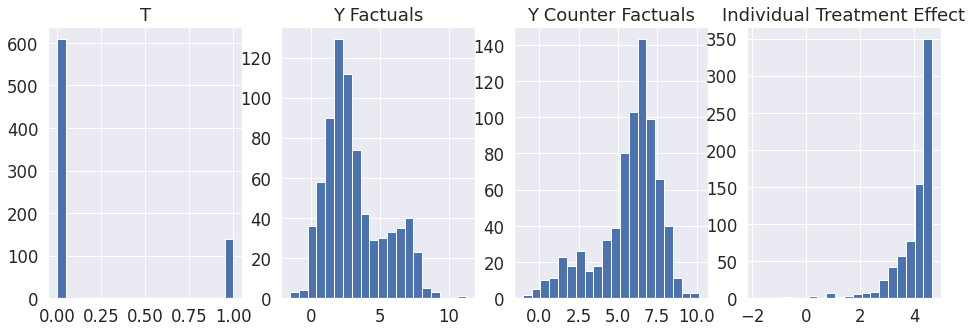

In [33]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].hist(T, bins=bins)
axs[1].hist(Yf, bins=bins)
axs[2].hist(Ycf, bins=bins)
axs[3].hist(ite, bins=bins)
axs[0].title.set_text('T')
axs[1].title.set_text('Y Factuals')
axs[2].title.set_text('Y Counter Factuals')
axs[3].title.set_text('Individual Treatment Effect')
sns.set()
plt.show()
fig.savefig("ihdp_TreatmentAndElse.pdf", dpi=1200)

In [34]:
print("Amount of 0 in T: ", np.count_nonzero(df['t'] == 0))
print("Amount of 1 in T: ", np.count_nonzero(df['t'] == 1))

Amount of 0 in T:  608
Amount of 1 in T:  139


As seen above one of the first things that come to mind are the difference in T.  Having a count of values we are able to see that the data for treatment is not balanced, having **81.39 %** _not treated_ and the remaining **18.61 %** _is_.

While the *ITE* is clearly skewed to the left, as *Ycf* is and therefore expecting that *Yf* skewes to the right.

In [35]:
np.mean(ite)

4.016066896118338

Due to the skewness of *ITE* we find that as expected the *ATE* is **4.016**.

## Preprocessing

In [36]:
x_train, x_test, y_train, y_test, t_train, t_test, ite_train, ite_test = train_test_split(X, Yf, T, ite, test_size=0.2)

In [37]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [38]:
rf = RandomForestRegressor()